In [2]:
install.packages("pacman")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



I wanted to investigate how major ETFs relate to the factors of the Fama-French 3 model, so I downloaded the relevant data and the Fama-French model, created a dataframe in R, and used kable to enhance the visuals.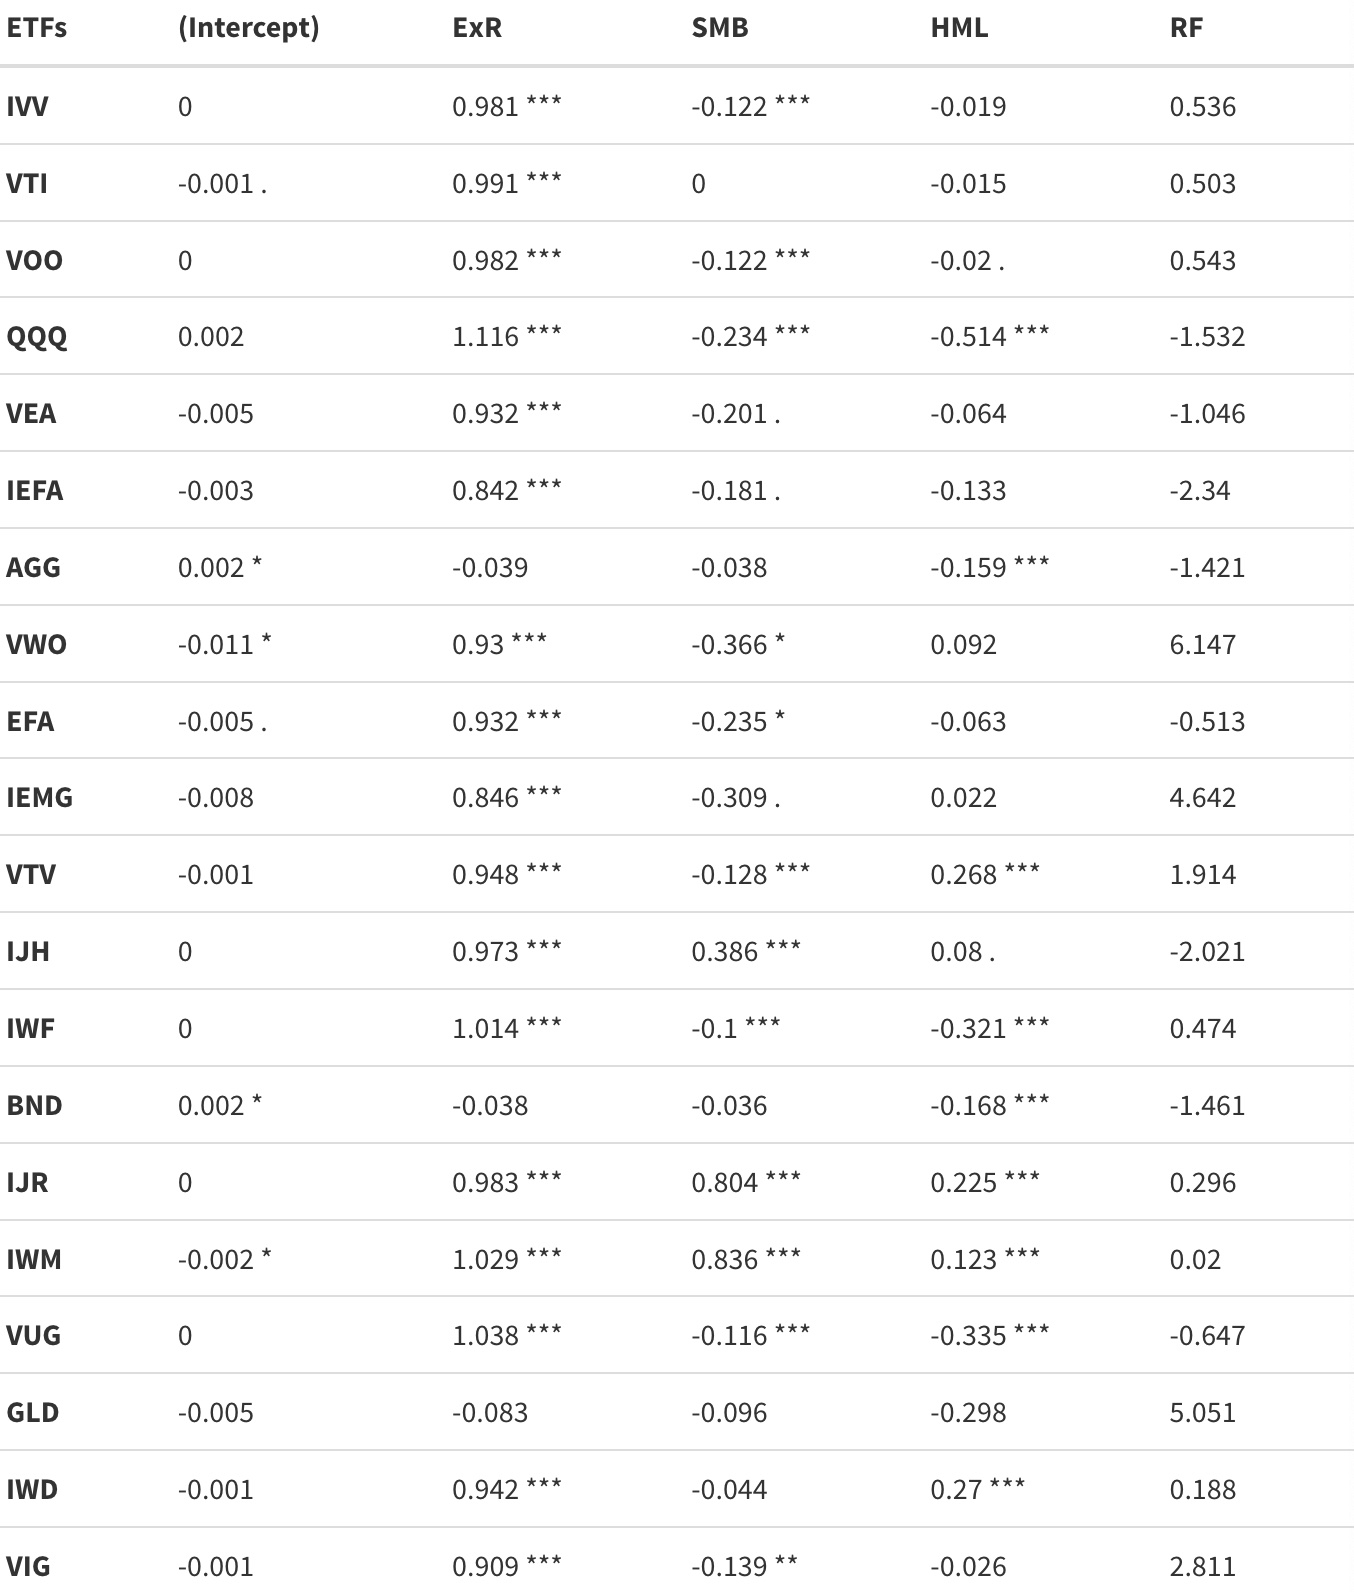

First of all, we should load the relevant packages using "pacman" package

In [3]:
pacman::p_load(frenchdata,purrr,tidyr,dplyr,tidyquant,broom,gtools,kableExtra)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘assertthat’



frenchdata installed

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘globals’, ‘later’, ‘listenv’, ‘parallelly’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘furrr’, ‘htmlwidgets’, ‘crosstalk’, ‘promises’, ‘Rcpp’, ‘warp’, ‘BH’, ‘fracdiff’, ‘lmtest’, ‘tseries’, ‘urca’, ‘RcppArmadillo’, ‘RcppRoll’, ‘future’, ‘quadprog’, ‘zoo’, ‘recipes’, ‘rsample’, ‘plotly’, ‘padr’, ‘slider’, ‘anytime’, ‘forecast’, ‘tsfeatures’, ‘PerformanceAnalytics’, ‘quantmod’, ‘lazyeval’, ‘Quandl’, ‘riingo’, ‘alphavantager’, ‘timetk’, ‘timeDate’, ‘TTR’, ‘xts’



tidyquant installed

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


gtools installed

Installing package into ‘/usr/local/lib/R/site-library’

and loaded major ETF tickers, defined as "ETFs"

In [4]:
ETFs = c("IVV", "VTI", "VOO", "QQQ", "VEA", "IEFA", "AGG", "VWO",
            "EFA","IEMG","VTV", "IJH", "IWF","BND", "IJR", "IWM", "VUG",
            "GLD", "IWD", "VIG", "VNQ", "USMV", "LQD", "VO", "VYM", "EEM",
            "VB", "VCSH", "XLF", "VCIT", "VEU", "XLK", "ITOT", "IVW", "BNDX",
            "VGT", "DIA", "BSV", "SHV", "IWB", "IWR", "TIP", "SCHF", "MBB", "SDY",
            "MDY", "SCHX", "IEF", "HYG", "DVY", "XLV", "SHY", "IXUS", "TLT", "IVE",
            "PFF", "IAU", "VXUS", "RSP", "SCHB", "VV", "GOVT", "EMB", "MUB", "QUAL",
            "XLY", "VBR", "EWJ", "XLP", "VGK", "SPLV", "MINT", "BIV", "IGSB", "EFAV",
            "VT", "GDX", "XLU", "IWS", "XLI", "SCHD", "IWP", "ACWI", "VMBS", "XLE", "JNK",
            "VOE", "FLOT", "IWV", "JPST", "SCZ", "IEI", "IWN", "DGRO", "VBK", "IGIB", "IWO")


Set the date from "2012-01-01" to "2019-01-01"

In [5]:
start = "2012-01-01" ; end = "2019-01-01"

1. you can see all list of Fama-French models via get_french_data_list()

2. Our purpose is to investigate how ETFs are related to the 3-factor model, so we will downloaded this model and preprocess "date" column

3. We'll use the filter() function to extract the data for that date.

In [11]:
frenchdata::get_french_data_list()$files_list %>% head

ff3_data = frenchdata::download_french_data("Fama/French 3 Factors")$subsets$data[[1]] %>%
  mutate(date = rollback(ymd(parse_date_time(date, "%Y%m") + months(1)))) %>%
  mutate_if(is.numeric, function(x) (x/100)) %>%
  rename(ExR = `Mkt-RF`) %>%
  filter(date >= start & date <= end)

name,file_url,details_url
<chr>,<chr>,<chr>
Fama/French 3 Factors,ftp/F-F_Research_Data_Factors_CSV.zip,Data_Library/f-f_factors.html
Fama/French 3 Factors [Weekly],ftp/F-F_Research_Data_Factors_weekly_CSV.zip,Data_Library/f-f_factors.html
Fama/French 3 Factors [Daily],ftp/F-F_Research_Data_Factors_daily_CSV.zip,Data_Library/f-f_factors.html
Fama/French 5 Factors (2x3),ftp/F-F_Research_Data_5_Factors_2x3_CSV.zip,Data_Library/f-f_5_factors_2x3.html
Fama/French 5 Factors (2x3) [Daily],ftp/F-F_Research_Data_5_Factors_2x3_daily_CSV.zip,Data_Library/f-f_5_factors_2x3.html
Portfolios Formed on Size,ftp/Portfolios_Formed_on_ME_CSV.zip,Data_Library/det_port_form_sz.html


New names:
• `` -> `...1`
New names:
• `` -> `...1`


1. Download ETFs stock data
2. Replace existing data with monthly data
3. Change data into log-return data
4. combine with ff3_data using right_join() function

In [7]:
data = tq_get(
  ETFs,
  from = start,
  to = end
) %>%
  group_by(symbol) %>%
  tq_transmute(
    select = adjusted,
    mutate_fun = to.monthly,
    indexAt = "lastof"
  ) %>%
  tq_transmute(
    select = adjusted,
    mutate_fun = periodReturn,
    type = "log"
  ) %>%
  pivot_wider(
    names_from = symbol,
    values_from = monthly.returns
  ) %>%
  slice(-1) %>%
  right_join(ff3_data,., by="date")

In [10]:
data %>% head

date,ExR,SMB,HML,RF,IVV,VTI,VOO,QQQ,VEA,⋯,FLOT,IWV,JPST,SCZ,IEI,IWN,DGRO,VBK,IGIB,IWO
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2012-02-29,0.0442,-0.0185,0.0043,0e+00,0.041255803,0.041319041,0.041927905,0.062130032,0.047685268,⋯,0.009137563,0.040852453,NA,0.051266812,-0.006246702,0.01445588,NA,0.037989346,0.012094850,0.03269383
2012-03-31,0.0311,-0.0064,0.0114,0e+00,0.032432592,0.030216139,0.032492879,0.049295338,0.003266614,⋯,0.002278850,0.029413978,NA,0.007754904,-0.005845481,0.03053458,NA,0.022280502,-0.001945371,0.02089327
2012-04-30,-0.0085,-0.0042,-0.0078,0e+00,-0.006607644,-0.006386171,-0.006390094,-0.011764385,-0.024090129,⋯,-0.004024697,-0.005538900,NA,-0.007754904,0.011856255,-0.01532879,NA,-0.009940281,0.006766573,-0.01777062
2012-05-31,-0.0619,0.0007,-0.0107,1e-04,-0.061975549,-0.064278475,-0.061915192,-0.073002081,-0.118422895,⋯,0.000180408,-0.062656921,NA,-0.121620049,0.008392957,-0.06274008,NA,-0.074741968,0.001072626,-0.07338547
2012-06-30,0.0389,0.0067,0.0062,0e+00,0.041216408,0.039654125,0.040525645,0.035573881,0.067478272,⋯,0.004391278,0.037398772,NA,0.040622661,-0.001981304,0.04871193,NA,0.047424046,0.004786760,0.05150520
2012-07-31,0.0079,-0.0274,-0.0002,0e+00,0.012354354,0.008713799,0.011970591,0.009925532,0.002530587,⋯,0.003658007,0.008793043,NA,-0.011969739,0.006948460,-0.01258039,NA,-0.013460571,0.014767424,-0.01864884


1. create linear model and input this model into data frame using map()
2. And make visuals of p-value via stars.pval()
3. extract the coefficient data using unnest()
4. extract ETFs, term, value columns and preprocess using pivot_wider()

In [8]:
factor_value = tibble(
  ETFs = ETFs,
  model = map(ETFs, ~ lm(get(.x) ~ ExR + SMB + HML + RF, data = data) %>%
                tidy %>%
                mutate(pvalue = stars.pval(p.value)))
) %>%
  unnest(model) %>%
  mutate(value = paste0(round(estimate, digits=3), " ", pvalue)) %>%
  select(ETFs,term,value) %>%
  pivot_wider(
    names_from = term,
    values_from = value
  )

In [9]:
factor_value %>% head

ETFs,(Intercept),ExR,SMB,HML,RF
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
IVV,0,0.981 ***,-0.122 ***,-0.019,0.536
VTI,-0.001 .,0.991 ***,0,-0.015,0.503
VOO,0,0.982 ***,-0.122 ***,-0.02 .,0.543
QQQ,0.002,1.116 ***,-0.234 ***,-0.514 ***,-1.532
VEA,-0.005,0.932 ***,-0.201 .,-0.064,-1.046
IEFA,-0.003,0.842 ***,-0.181 .,-0.133,-2.34


Make kable table and Add footprint to enhance visualize effect

In [ ]:
factor_value$ETFs = cell_spec(factor_value$ETFs, bold = T)

factor_value %>%
  kable("html", escape = F) %>%
  kable_styling() %>%
  add_footnote(c(paste0("Date from: ",start," to: ",end),
                 "P-value : *** if <0.001, ** if < 0.01, * if < 0.05"))


you can get the result as below :